<a href="https://colab.research.google.com/github/safi50/FashionMNIST-Classification-with-PyTorch/blob/main/PyTorch_CNN_Model_FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

## Downloading FashionMNIST Dataset

In [ ]:
train_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms.ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = transforms.ToTensor(),
    target_transform = None
)

100%|██████████| 26421880/26421880 [00:03<00:00, 8398055.62it/s] 


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 137228.30it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2568926.29it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5189203.80it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



## Visualizing Image


torch.Size([1, 28, 28])


Text(0.5, 1.0, 'Ankle boot')

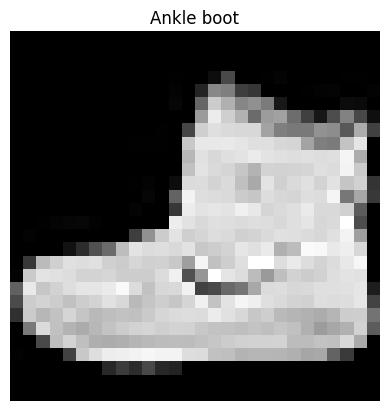

In [ ]:
image, label = train_data[0]
print(image.shape)
plt.imshow(image.squeeze(), cmap = "gray")
plt.axis(False)
plt.title(train_data.classes[label])

## Setting Up DataLoader
* Dataloader converts Dataset into a python iterable format
* Also convert data into batches

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              shuffle = True,
                              batch_size = BATCH_SIZE)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = False)
print(f"Len of Train DataLoader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Len of Test DataLoader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Len of Train DataLoader: 1875 batches of 32
Len of Test DataLoader: 313 batches of 32


In [ ]:
# Check what's inside data loader
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape # (batch_size, color_channels, length, width) , (num outputs)

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

## Device Agnostic Code:

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Getting Helper Functions From GitHub

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

helper_functions.py already exists, skipping download


# Functionizing Train and Test Steps

In [ ]:


def train_step(model: torch.nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : torch.nn.Module,
               optimizer : torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):

  # Train loss and accuracy per batch
  train_loss , train_acc = 0,0
  model.to(device) # Loading model to available device

  for batch, (X, Y) in enumerate(data_loader):
    X,Y = X.to(device), Y.to(device)

    Y_pred = model(X) # Forward Pass
    #Cumalative Loss and Accuracy per Epoch
    loss = loss_fn(Y_pred, Y)
    train_loss += loss
    train_acc += accuracy_fn(y_true = Y ,
                             y_pred = Y_pred.argmax(dim = 1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

  # Train Loss and accuracy per epoch
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:2f}")


# Function for Testing Loop
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  test_loss , test_acc = 0,0
  model.to(device)

  model.eval()
  with torch.inference_mode():
    for X,Y in data_loader:

      X,Y = X.to(device), Y.to(device)
      test_preds = model(X)

      loss = loss_fn(test_preds, Y)
      test_loss += loss
      # Go from logits => pred_labels using argmax
      test_acc += accuracy_fn(y_true = Y,
                              y_pred = test_preds.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:2f}")



## Making a CNN Model
### Model Architecture: TinyVGG - https://poloclub.github.io/cnn-explainer/


In [ ]:
class FashionMNISTModel(nn.Module):

  def __init__(self, input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()

    self.layerBlock1 = nn.Sequential(
        # 2D convolution layer
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(), # Non Linear Layer
        nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
        nn.ReLU(),
        # Pooling Layer
        nn.MaxPool2d(kernel_size = 2,
                     stride = 2)
    )

    self.layerBlock2 = nn.Sequential(
      # 2D convolution layer
      nn.Conv2d(in_channels = hidden_units,
                out_channels = hidden_units,
                kernel_size = 3,
                stride = 1,
                padding = 1),
      nn.ReLU(), # Non Linear Layer
      nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
      nn.ReLU(),
      # Pooling Layer
      nn.MaxPool2d(kernel_size = 2,
                    stride = 2)
    )


    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features =  hidden_units * 7 * 7,
                  out_features = output_shape)
    )

  def forward(self, x: torch.Tensor):
    x = self.layerBlock1(x)
    # print(x.shape)
    x = self.layerBlock2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)

    return x


# Creating a model instance
# input shape is 1 because our data is grayscale i.e., only 1 color channel
model = FashionMNISTModel(input_shape= 1,
                          hidden_units = 10,
                          output_shape = len(train_data.classes))
model.to(device)

FashionMNISTModel(
  (layerBlock1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layerBlock2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)


### Trick to find Classification Layer Dimensions

*  Trick to finding right dimensions as input for classification layer
  is passing a dummy image to the model

In [ ]:
# random image
image , label = train_data[100]

# pass sample image through model to find shapes of outputs of subsequent layers
# and give input shape to classifier accordingly
model(image.unsqueeze(0))

tensor([[ 0.0211, -0.0279,  0.0024,  0.0382,  0.0256,  0.0001, -0.0407, -0.0232,
          0.0012, -0.0606]], grad_fn=<AddmmBackward0>)

## Creating a Loss Function and Optimizer

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr = 0.1)

## Training and Testing Loop

In [ ]:
%%time
from tqdm.auto import tqdm
torch.manual_seed(42)
epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"-------- Epoch {epoch}: --------\n")
  train_step(data_loader = train_dataloader,
             model = model,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy_fn = accuracy_fn,
             device = device)

  test_step(data_loader=test_dataloader,
            model = model,
            loss_fn = loss_fn,
            accuracy_fn = accuracy_fn,
            device  = device)



  0%|          | 0/5 [00:00<?, ?it/s]

-------- Epoch 0: --------

Train Loss: 0.61041 | Train Accuracy: 77.946667
Test Loss: 0.38746 | Test Accuracy: 86.142173
-------- Epoch 1: --------

Train Loss: 0.35834 | Train Accuracy: 87.098333
Test Loss: 0.36320 | Test Accuracy: 86.950879
-------- Epoch 2: --------

Train Loss: 0.32221 | Train Accuracy: 88.401667
Test Loss: 0.31858 | Test Accuracy: 88.618211
-------- Epoch 3: --------

Train Loss: 0.30345 | Train Accuracy: 89.098333
Test Loss: 0.29616 | Test Accuracy: 89.027556
-------- Epoch 4: --------

Train Loss: 0.29097 | Train Accuracy: 89.493333
Test Loss: 0.32906 | Test Accuracy: 87.949281
CPU times: user 3min 57s, sys: 359 ms, total: 3min 57s
Wall time: 3min 58s


## Visualize Predictions

### Making Predictions Function

In [ ]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


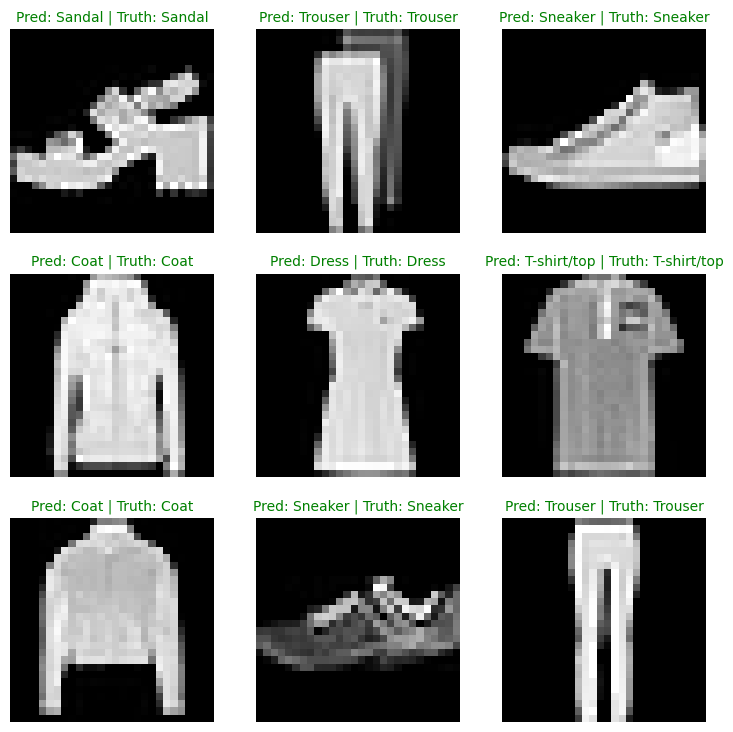

In [ ]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({train_data.classes[test_labels[0]]})")


# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model,
                             data=test_samples)

pred_classes = pred_probs.argmax(dim=1)



# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = train_data.classes[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = train_data.classes[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## Making a Confusion Matrix

* First - Make Predictions for Test Data

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

* Install necessary library else import it

In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 8.8 MB/s eta 0:00:00
mlxtend version: 0.22.0


### Plotting Confusion Matrix

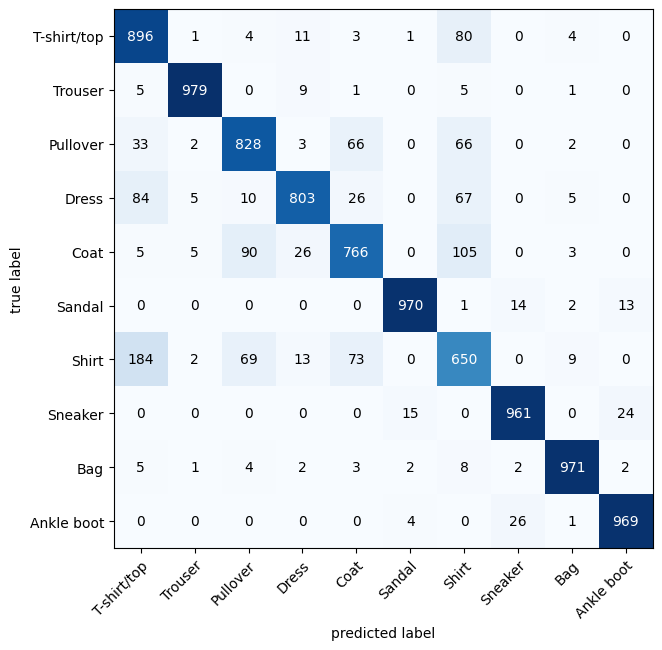

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confusion_mat = ConfusionMatrix(num_classes = len(train_data.classes), task = "multiclass")
confusion_mat_tensor = confusion_mat(preds = y_pred_tensor,
                                     target = test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat = confusion_mat_tensor.numpy(),
    class_names = train_data.classes,
    figsize = (10,7)
)

## Saving and Loading Model

### Save Model

In [ ]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "FashionMNISTModel.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/FashionMNISTModel.pth


### Load Model

In [ ]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model = FashionMNISTModel(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model.to(device)